In [1]:
from torch import nn
import numpy as np
import torch.nn.functional as F

This notebook uses code from [this](https://github.com/pbloem/former/blob/master/former/modules.py) in an effort to understand the details of the paper: [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)

In [2]:
# We'll come back to this.

class SelfAttention(nn.Module):
    """
    Canonical implementation of multi-head self attention.
    """

    def __init__(self, emb, heads=8, mask=False):
        """
        :param emb:
        :param heads:
        :param mask:
        """

        super().__init__()

        assert emb % heads == 0, f'Embedding dimension ({emb}) should be divisible by nr. of heads ({heads})'

        self.emb = emb
        self.heads = heads
        self.mask = mask

        s = emb // heads
        # - We will break the embedding into `heads` chunks and feed each to a different attention head

        self.tokeys    = nn.Linear(emb, emb, bias=False)
        self.toqueries = nn.Linear(emb, emb, bias=False)
        self.tovalues  = nn.Linear(emb, emb, bias=False)

        self.unifyheads = nn.Linear(emb, emb)

    def forward(self, x):

        b, t, e = x.size()
        h = self.heads
        assert e == self.emb, f'Input embedding dim ({e}) should match layer embedding dim ({self.emb})'

        s = e // h

        keys    = self.tokeys(x)
        queries = self.toqueries(x)
        values  = self.tovalues(x)

        keys    = keys.view(b, t, h, s)
        queries = queries.view(b, t, h, s)
        values  = values.view(b, t, h, s)

        # -- We first compute the k/q/v's on the whole embedding vectors, and then split into the different heads.
        #    See the following video for an explanation: https://youtu.be/KmAISyVvE1Y

        # Compute scaled dot-product self-attention

        # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, s)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, s)
        values = values.transpose(1, 2).contiguous().view(b * h, t, s)

        queries = queries / (e ** (1/4))
        keys    = keys / (e ** (1/4))
        # - Instead of dividing the dot products by sqrt(e), we scale the keys and values.
        #   This should be more memory efficient

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))

        assert dot.size() == (b*h, t, t)

        if self.mask: # mask out the upper half of the dot matrix, excluding the diagonal
            mask_(dot, maskval=float('-inf'), mask_diagonal=False)

        dot = F.softmax(dot, dim=2)
        # - dot now has row-wise self-attention probabilities

        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, s)

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, s * h)

        return self.unifyheads(out)

In [35]:
class TransformerBlock(nn.Module):
    def __init__(
        self,
        emb_size: int,
        heads: int,\
        seq_length,
        ff_hidden_mult=4,
        dropout=0.0,
        pos_embedding=None
):
        super().__init__()

        self.attention = SelfAttention(emb_size)

        self.norm1 = nn.LayerNorm(emb_size)
        self.norm2 = nn.LayerNorm(emb_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(emb_size, ff_hidden_mult * emb_size),
            nn.ReLU(),
            nn.Linear(ff_hidden_mult * emb_size, emb_size)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attention_out = self.attention(x)
        x = self.norm1(attention_out + x)
        x = self.dropout(x)
        
        feed_forward = self.feed_forward(x)
        x = self.norm2(feed_forward + x)
        x = self.dropout(x)
        
        return x

In [36]:
class Transformer(nn.Module):
    def __init__(
        self,
        emb_size: int,
        heads: int,
        num_tokens: int,
        seq_length: int,
        max_pool: bool = True,
        dropout: int=0
    ):
        super().__init__()
        
        self.num_tokens, self.max_pool = num_tokens, max_pool
        
        self.token_embedding = nn.Embedding(embedding_dim=emb_size, num_embeddings=num_tokens)
        self.pos_embedding = nn.Embedding(embedding_dim=emb_size, num_embeddings=seq_length)
        
        tblocks = []
        for i in range(heads):
            tblocks.append(TransformerBlock(emb_size=emb_size, heads=heads, seq_length=seq_length))
            
        self.tblocks = nn.Sequential(*tblocks)
        
        self.toprobs = nn.Linear(emb_size, 2)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        """
        x: Batch by sequence length integer tensor of token indices.
        
        Return: predicted log-probs vectors for each token based on preceding tokens.
        """
        tokens = self.token_embedding(x)
        batch_size, seq_length, emb_size = tokens.size()
        
        positions = self.pos_embedding(torch.arange(t, device=d()))[None, :, :].expand(b, t, e)
        x = tokens + positions
        x = self.dropout(x)
        
        x = self.tblocks(x)

        x = x.max(dim=1)[0] if self.max_pool else x.mean(dim=1) # pool over the time dimension

        x = self.toprobs(x)

        return F.log_softmax(x, dim=1)

Next steps:

1. Create a basic input and output example.
2. Add a batch dimension.
3. Feed it into the model and view the returned sizes.
4. Use it to breakdown the inside of Transformer./

In [37]:
vocab = {'this': 0, 'is': 1, 'awesome': 2, 'i': 3, 'hated': 4, 'it': 5}

train_data = [
    {'text': 'this is awesome', 'label': True},
    {'text': 'i hated it', 'label': False}
]

def tokenise(txt: str):
    return txt.split()

def numericise(tokens):
    return [vocab[t] for t in tokens]

tokens = []
labels = []
for row in train_data:
    tokens.append(numericise(tokenise(row['text'])))
    labels.append(row['label'])
tokens = np.array(tokens)
labels = np.array(labels)

In [38]:
print(tokens); print(tokens.shape)

In [39]:
labels, labels.shape

In [40]:
tokens = np.array(tokens)
labels = np.array(labels)

In [41]:
tokens.shape, labels.shape

In [42]:
EMB_SIZE = 512

In [43]:
model = Transformer(emb_size=EMB_SIZE, heads=6, num_tokens=3, seq_length=3)

In [44]:
import torch

In [45]:
tokens

In [46]:
tokens_arr = torch.from_numpy(tokens)

Before breaking down the Transformer, let's look at the inputs to the model.

We'll firstly create a token embedding. Which is a structure that assigns a vector of 512 for each token in our vocab.

#### Token embedding

In Attention Is All You Need, they set all outputs sizes to 512, including embeddings. So we'll do that.

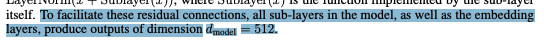

In [47]:
embedding_size = 512

In [48]:
token_embedding = nn.Embedding(embedding_dim=embedding_size, num_embeddings=len(vocab.keys()))

In [49]:
token_embedding

In [50]:
token_embedding(torch.from_numpy(np.array([0, 1])))

### Position embedding

In [51]:
seq_length = 3  # Each training example has 3 words in the sequence.

pos_embedding = nn.Embedding(embedding_dim=embedding_size, num_embeddings=seq_length)

Now, in the forward pass, we take the embedding values for our tokens:

In [52]:
tokens_arr.shape

In [53]:
tokens = token_embedding(tokens_arr)

In [54]:
tokens.shape

In [55]:
tokens.shape

In [56]:
batch_size, seq_length, emb_length = tokens.size()

What are we doing here?

If I have a sequence length of 3, then the position array is just: [0, 1, 2]

In [57]:
torch.arange(seq_length)

In [58]:
position_sequence = torch.arange(seq_length)
position_sequence.shape

In [59]:
positions = pos_embedding(position_sequence)

We add the batch dimension, them duplicate for each sequence.

In [60]:
positions = positions[None,:,:]
positions.shape

Now duplicate that so there's one for each of our sequences.

In [61]:
positions = positions.expand(batch_size, seq_length, emb_length)
positions.shape

Now we add these tokens.

In [62]:
x = tokens + positions

This input can be fed into the neural network.



### Encoder

The encoder is composed of a stack of N = 6 identical layers, which we'll call `TransformerBlock`

In [68]:
tblocks = [TransformerBlock(emb_size=embedding_size, heads=8, seq_length=3)] * 6

In [69]:
model = nn.Sequential(*tblocks)

In [71]:
model[0]

In [72]:
model(x).shape

Each layer has two sub-layers. The first is a *multi-head self-attention mechanism*, and the second is a simple, positionwise fully connected feed-forward network.

Let's explore the multi-head self-attention mechanism first.

#### Multi-head self-attention

The paper says:

*An attention function can be described as mapping a query and a set of key-value pairs to an output,
where the query, keys, values, and output are all vectors. The output is computed as a weighted sum
of the values, where the weight assigned to each value is computed by a compatibility function of the
query with the corresponding key.*

The code creates 4 Linear layers that have embedding_size inputs and outputs.

In [73]:
tokeys = nn.Linear(embedding_size, embedding_size, bias=False)
toqueries = nn.Linear(embedding_size, embedding_size, bias=False)
tovalues = nn.Linear(embedding_size, embedding_size, bias=False)

unifyheads = nn.Linear(embedding_size, embedding_size)

We feed out token and position concatted embedding vector into the layers.

In [74]:
keys = tokeys(x)
queries = toqueries(x)
values = tovalues(x)

In [75]:
keys.shape, queries.shape, values.shape

Now we split those into 6 head values.

In [79]:
num_heads = 8
head_size = embedding_size // num_heads
head_size

In [80]:
batch_size, seq_length, emb_length = x.size()

In [81]:
keys = keys.view(batch_size, seq_length, num_heads, head_size)
queries = queries.view(batch_size, seq_length, num_heads, head_size)
values  = values.view(batch_size, seq_length, num_heads, head_size)

The next step is to "fold the heads into the batch dimension". Why we do this i'm not sure, but we're converting the size from:

batch, seq_len, num_heads, head_size

into

batch_size * num_heads, seq_length, head_size

In [82]:
keys.shape

In [90]:
keys_transposed = keys.transpose(1, 2)
keys_transposed.shape


When you call contiguous() , it actually makes a copy of the tensor such that the order of its elements in memory is the same as if it had been created from scratch with the same data.
https://stackoverflow.com/questions/48915810/pytorch-what-does-contiguous-do

In [93]:
# This converts a view into a tensor that acts as if being created from scratch.
keys_contiguous = keys.transpose(1, 2).contiguous()
keys_contiguous.shape

In [94]:
keys_view = keys_contiguous.view(batch_size * num_heads, seq_length, head_size)
keys_view.shape

We do that for keys, queries and values.

In [95]:
keys = keys.transpose(1, 2).contiguous().view(batch_size * num_heads, seq_length, head_size)
queries = queries.transpose(1, 2).contiguous().view(batch_size * num_heads, seq_length, head_size)
values = values.transpose(1, 2).contiguous().view(batch_size * num_heads, seq_length, head_size)

This code I don't get. Something about scaling by embedding size

In [96]:
queries = queries / (embedding_size ** (1/4))
keys = keys / (embedding_size ** (1/4))

Now we take a dot product of queries and keys, then scale. Need to understand the `bmm` function.

In [99]:
dot = torch.bmm(queries, keys.transpose(1, 2))

We now convert dot into row-wise self-attention probabilities.

In [108]:
dot = F.softmax(dot, dim=2)
dot.shape

We now apply self-attention to the values.

In [109]:
out = torch.bmm(dot, values).view(batch_size, num_heads, seq_length, head_size)
out.shape

Now we swap num_heads and seq_length before unifying heads.

In [110]:
out = out.transpose(1, 2)
out.shape

In [111]:
out = out.contiguous().view(batch_size, seq_length, num_heads * head_size)
out.shape

Finally we unify heads.

In [112]:
out = unifyheads(out)
out.shape